# Question 1. 2D kernel density estimator

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

from scipy.stats import gaussian_kde
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity

import warnings
warnings.filterwarnings('ignore')

### (a) Read in the bequests data as a 78 x 7 NumPy array. Plot the 2D empirical histogram of these data as a 3D surface plot with age and income group on the x-axis and y-axis and the histogram density on the z-axis using a 3D surface plot tool (not a 3D bar histogram tool). Make sure that the axes are labeled correctly. And make sure that your 3D histogram is presented from a perspective that allows a viewer to see that data (don’t let the data be hidden by a poor angle of the plot.) 

In [3]:
bq_data = np.loadtxt('data/BQmat_orig.txt', delimiter=',')

In [4]:
# Some diagnostics
print('Shape of bq_data', bq_data.shape)
print('Bequest distribution by income group:',
      bq_data.sum(axis=0))
print('Sum of all probabilities', bq_data.sum())

Shape of bq_data (78, 7)
Bequest distribution by income group: [ 0.01214584  0.00817072  0.01590964  0.0139963   0.01383075  0.06927237
  0.86667437]
Sum of all probabilities 1.0


<IPython.core.display.Javascript object>


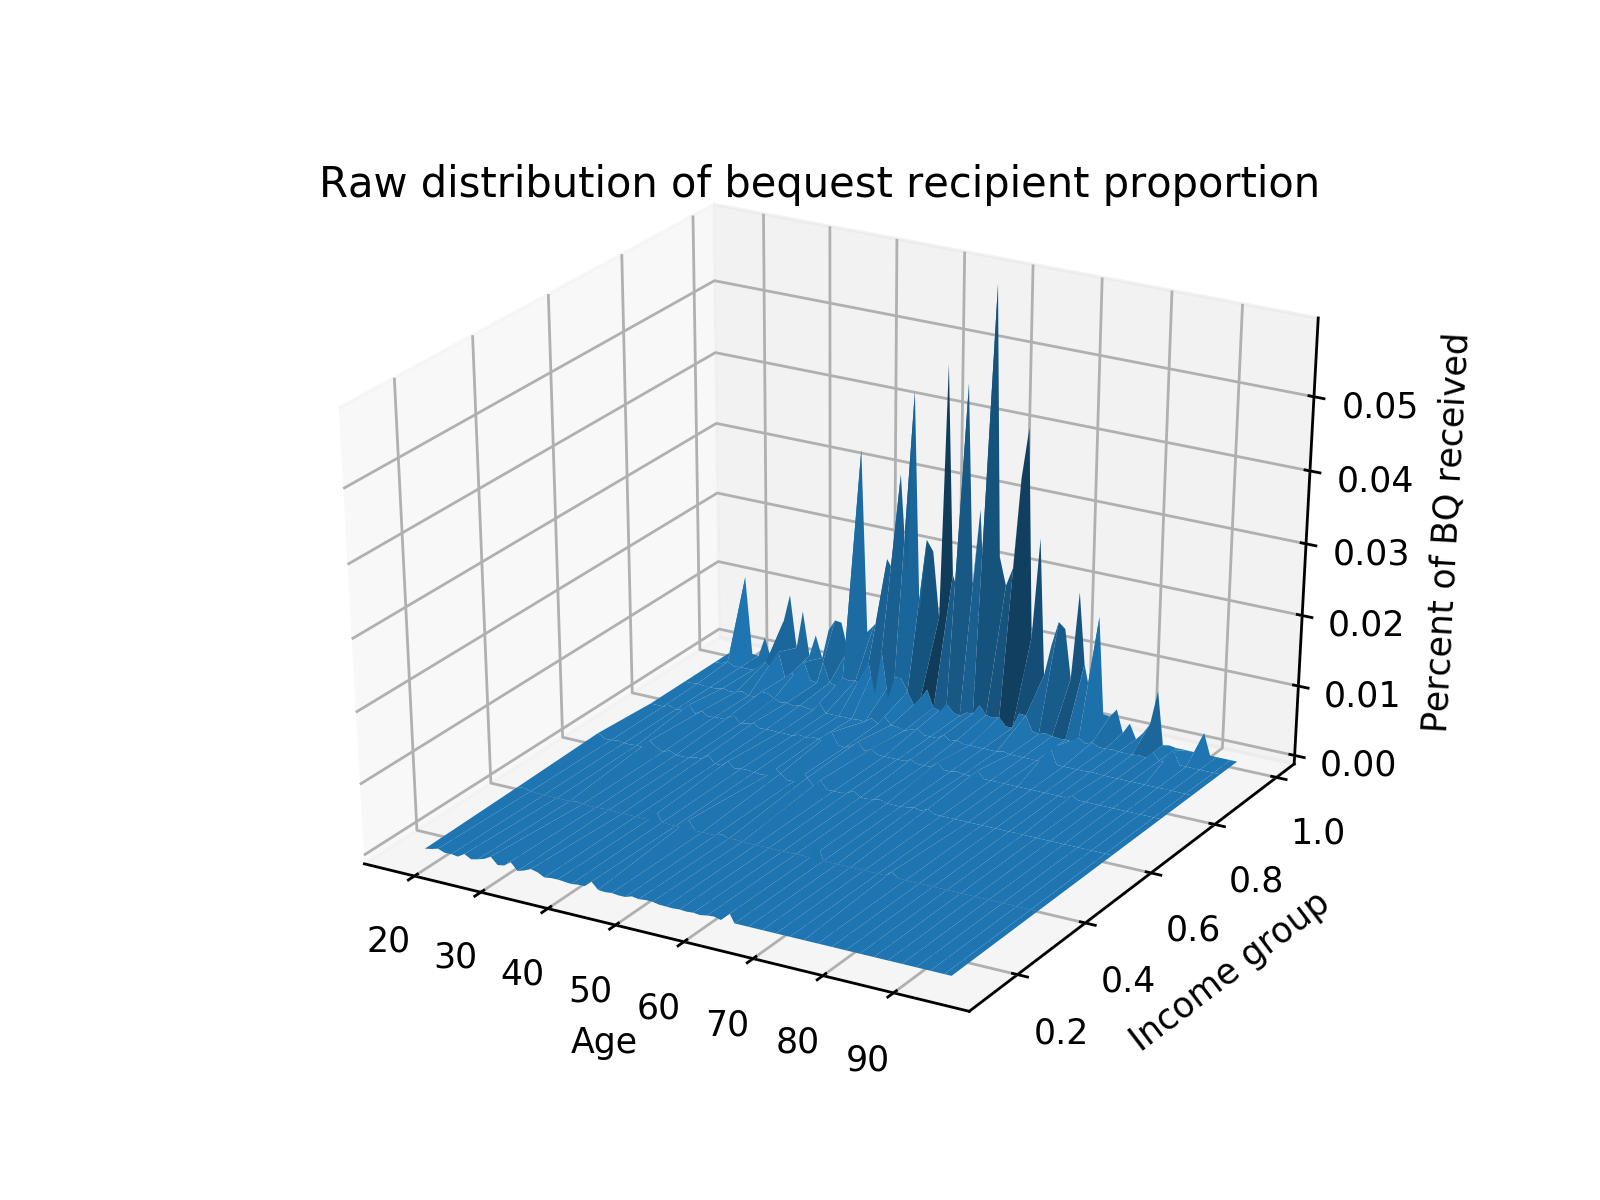

In [5]:
# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(18, 96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income group')
ax.set_zlabel('Percent of BQ received')
plt.show()

#### Comment: 
The above figure shows that, in terms of "Income group", high income groups receive most of the inheritances; in terms of "Age", people whose age is between about 35 to 75 receive most of the inheritances.

### (b) Fit a bivariate kernel density estimator to the data. Use a Gaussian kernel. Choose a bandwidth parameter λ that you think is best. Justify your choice of that parameter. Plot the surface of your chosen kernel density estimator. Make sure that the axes are labeled correctly. And make sure that your 3D histogram is presented from a perspective that allows a viewer to see that data. What is the estimated density for bequest recipients who are age 61 in the 6th lifetime income category (j = 6, 90th to 99th percentile).

In [7]:
# Get the best bandwidteh parameter
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(bq_data)))
grid.fit(bq_data)

GridSearchCV(cv=sklearn.cross_validation.LeaveOneOut(n=78),
       error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([  0.1    ,   0.10476, ...,   9.54548,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [8]:
grid.best_params_["bandwidth"]

0.10000000000000001

#### Comment:
Therefore, the best bandwidth parameter $\lambda$ is about 0.1 after using cross-validation method.

In [9]:
bandwidth = 0.1

In [11]:
prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)
lrg_samp = 70000
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(age_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of ability type values
for abil, num_j in zip(lambdas_mdpts, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)

data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=bandwidth)

In [12]:
age_vec = np.arange(18, 96)
abils_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
abils_mat, ages_mat = np.meshgrid(lambdas_mdpts, age_vec)

In [13]:
coords = np.vstack([item.ravel() for item in [ages_mat, abils_mat]])
BQkde = density(coords).reshape(age_mat.shape)
BQkde_scaled = BQkde / BQkde.sum()

<IPython.core.display.Javascript object>


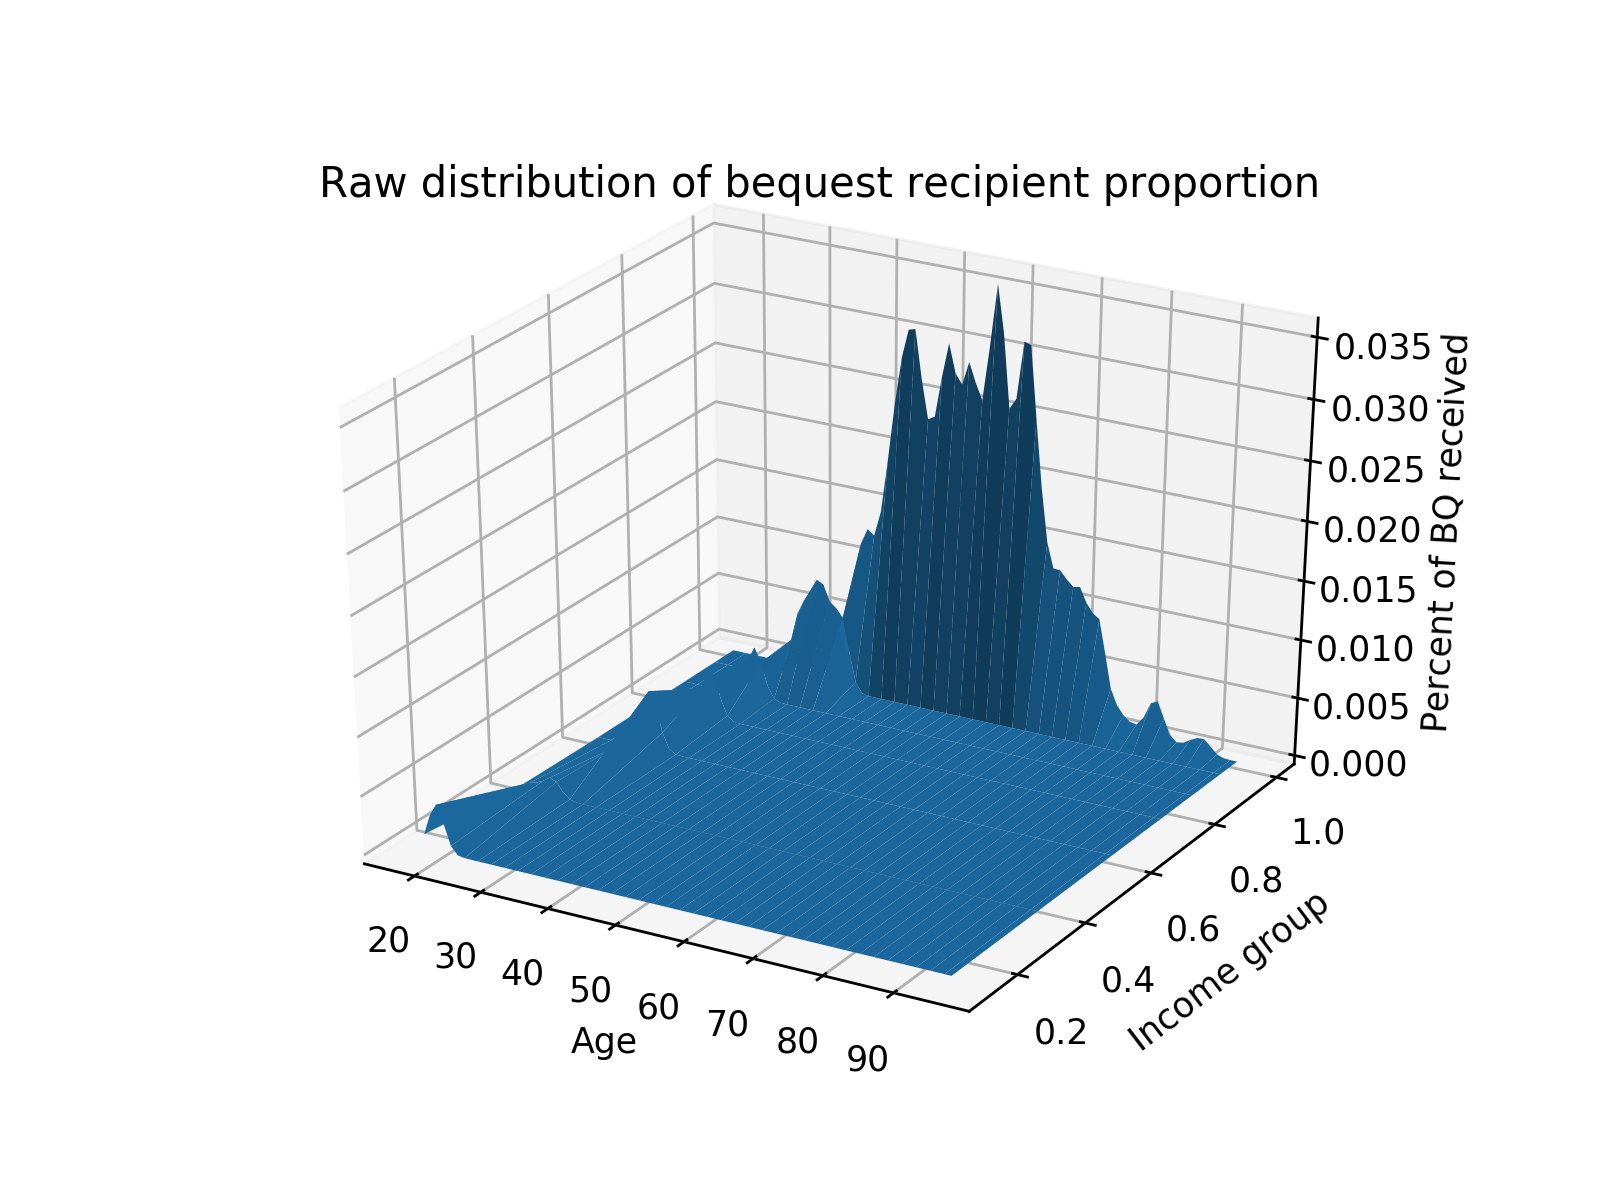

In [14]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(ages_mat, abils_mat, BQkde_scaled)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income group')
ax.set_zlabel('Percent of BQ received')
plt.show()

In [15]:
BQkde_scaled[61-18+1, 5]

7.8448627770277143e-07

#### Comment:
The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is about 7.8448627770277143e-07.

The second figure shows similar results with the first figure: in terms of "Income group", high income groups receive most of the inheritances; in terms of "Age", people whose age is between about 35 to 75 receive most of the inheritances.